# TimeEval parameter optimization result analysis (Part 4)

In [1]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "test-cases"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-10-11_optim-part4"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6')]


Selecting:
Data path: /home/projects/akita/data/test-cases
Result path: /home/projects/akita/results/2021-10-11_optim-part4


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# add dataset_name column
df["dataset_name"] = df["dataset"].str.split(".").str[0]

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-10-11_optim-part4


Extract target optimized parameter names that were iterated in this run (per algorithm):

In [4]:
algo_param_mapping = {}
algorithms = df["algorithm"].unique()
param_ignore_list = ["max_anomaly_window_size", "anomaly_window_size", "neighbourhood_size", "window_size", "n_init_train", "embed_dim_range"]

for algo in algorithms:
    param_sets = df.loc[df["algorithm"] == algo, "hyper_params"].unique()
    param_sets = [json.loads(ps) for ps in param_sets]
    param_names = np.unique([name for ps in param_sets for name in ps if name not in param_ignore_list])
    search_space = set()
    for param_name in param_names:
        values = []
        for ps in param_sets:
            try:
                values.append(ps[param_name])
            except:
                pass
        values = np.unique(values)
        if values.shape[0] > 1:
            search_space.add(param_name)
    algo_param_mapping[algo] = list(search_space)

for algo in algo_param_mapping:
    print(algo, algo_param_mapping[algo])

PCI []
PhaseSpace-SVM ['project_phasespace', 'nu', 'coef0', 'gamma', 'degree', 'kernel', 'tol']
PST ['sim']
Random Black Forest (RR) ['bootstrap']
SAND ['alpha']


Extract optimized parameters and their values (columns: optim_param_name and optim_param_value) for each experiment:

In [5]:
def extract_hyper_params(algo):
    param_names = algo_param_mapping[algo]
    def extract(value):
        params = json.loads(value)
        result = None
        for name in param_names:
            try:
                value = params[name]
                if isinstance(value, list):
                    value = repr(value)
                result = pd.Series([name, value], index=["optim_param_name", "optim_param_value"])
                break
            except KeyError:
                pass
        if result is None:
            return pd.Series([np.nan, np.nan], index=["optim_param_name", "optim_param_value"])
        return result
    return extract

df[["optim_param_name", "optim_param_value"]] = ""
for algo in algo_param_mapping:
    df_algo = df.loc[df["algorithm"] == algo]
    df.loc[df_algo.index, ["optim_param_name", "optim_param_value"]] = df_algo["hyper_params"].apply(extract_hyper_params(algo))

Extract window size parameters (dependent params) and convert them into multiples of the dataset period size:

In [6]:
dependent_param_names = ["neighbourhood_size", "window_size"]

def extract_window_param(value, param_name=""):
    params = json.loads(value)
    try:
        return params[param_name]
    except KeyError:
        return 0

for param_name in dependent_param_names:
    s_windows = df["hyper_params"].apply(extract_window_param, param_name=param_name)
    df2 = df[s_windows > 0][["dataset"]].copy()
    df2[param_name] = s_windows[df2.index]
    df2["period_size"] = df2["dataset"].apply(lambda d: dmgr.get(("GutenTAG", d)).period_size)
    df2["optim_param_name"] = param_name
    df2["optim_param_value"] = df2[param_name] / df2["period_size"]
    df2["optim_param_value"] = (df2["optim_param_value"]
                                .fillna(df2[param_name])
                                .round(1)
                                .replace(50., 0.5)
                                .replace(100, 1.0)
                                .replace(150, 1.5)
                                .replace(200, 2.0))
    df.loc[df2.index, ["optim_param_name", "optim_param_value"]] = df2[["optim_param_name", "optim_param_value"]]

Define utility functions

In [7]:
def load_scores_df(algorithm_name, dataset_id, optim_params, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]) & (df["optim_param_name"] == optim_params[0]) & (df["optim_param_value"] == optim_params[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [8]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_name, use_plotly: bool = default_use_plotly, **kwargs):
    if isinstance(algorithm_name, tuple):
        algorithms = [algorithm_name]
    elif not isinstance(algorithm_name, list):
        raise ValueError("Please supply a tuple (algorithm_name, optim_param_name, optim_param_value) or a list thereof as first argument!")
    else:
        algorithms = algorithm_name
    # construct dataset ID
    dataset_id = ("GutenTAG", f"{dataset_name}.unsupervised")

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[df["dataset_name"] == dataset_name, "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()

    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo, optim_param_name, optim_param_value in algorithms:
        optim_params = f"{optim_param_name}={optim_param_value}"
        algos.append((algo, optim_params))
        # get algorithm metric results
        try:
            auroc[(algo, optim_params)] = df.loc[
                (df["algorithm"] == algo) & (df["dataset_name"] == dataset_name) & (df["optim_param_name"] == optim_param_name) & (df["optim_param_value"] == optim_param_value),
                "ROC_AUC"
            ].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")
            auroc[(algo, optim_params)] = -1
            skip_algos.append((algo, optim_params))
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[(algo, optim_params)] = load_scores_df(algo, ("GutenTAG", f"{dataset_name}.{training_type}"), (optim_param_name, optim_param_value)).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name} with params {optim_params}.")
            df_scores[(algo, optim_params)] = np.nan
            skip_algos.append((algo, optim_params))
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=f"channel-{i}"), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)

    for item in algorithms:
        algo, optim_params = item
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[item], name=f"{algo}={auroc[item]:.4f} ({optim_params})"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=f"channel-{i}")
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")

    for item in algorithms:
        algo, optim_params = item
        axs[1].plot(df_scores.index, df_scores[item], label=f"{algo}={auroc[item]:.4f} ({optim_params})")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}")
    fig.tight_layout()
    return fig

## Parameter assessment

In [9]:
sort_by = ("ROC_AUC", "mean")
metric_agg_type = ["min", "mean", "median"]
time_agg_type = "mean"
aggs = {
    "PR_AUC": metric_agg_type,
    "ROC_AUC": metric_agg_type,
    "train_main_time": time_agg_type,
    "execute_main_time": time_agg_type,
    "repetition": "count"
}

df_tmp = df.reset_index()
df_tmp = df_tmp.groupby(by=["algorithm", "optim_param_name", "optim_param_value"]).agg(aggs)
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.sort_values(by=["algorithm", "optim_param_name", sort_by], ascending=False)
df_tmp = df_tmp.set_index(["algorithm", "optim_param_name", "optim_param_value"])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp)

PR_AUC  \
                                                                    min   
algorithm                optim_param_name   optim_param_value             
SAND                     alpha              0.5                0.001166   
                                            0.1                0.000960   
                                            0.9                0.001138   
Random Black Forest (RR) bootstrap          0                       NaN   
                                            1.0                     NaN   
PhaseSpace-SVM           tol                0.0001             0.000116   
                                            1e-05              0.000116   
                                            0.001              0.000116   
                                            0.01               0.000116   
                                            0.1                0.000116   
                         project_phasespace 1.0                0.000151   
                                            0                  0.000116   
                         nu                 0.35               0.000127   
                                            0.5                0.000116   
                                            0.65               0.000106   
                         kernel             rbf                0.000116   
                                            linear             0.000050   
                                            sigmoid            0.000050   
                                            poly               0.000050   
                                            rbf-exp                 NaN   
                                            rbf-gaussian            NaN   
                         gamma              0.8                0.003049   
                                            1.0                0.003298   
                                            0.5                0.001337   
                         degree             2.0                0.000116   
                                            3                  0.000116   
                                            4                  0.000116   
                         coef0              0                  0.000116   
                                            1.0                0.000116   
                                            10                 0.000116   
                                            100                0.000116   
PST                      window_size        1.0                0.000050   
                                            1.5                0.000057   
                                            0.5                0.000050   
                                            2.0                0.000056   
                         sim                simn                    NaN   
                                            simo                    NaN   
PCI                      window_size        0.5                0.001966   
                                            1.0                0.001483   
                                            1.5                0.001056   
                                            2.0                0.001065   

                                                                         \
                                                                   mean   
algorithm                optim_param_name   optim_param_value             
SAND                     alpha              0.5                0.511353   
                                            0.1                0.500990   
                                            0.9                0.466757   
Random Black Forest (RR) bootstrap          0                       NaN   
                                            1.0                     NaN   
PhaseSpace-SVM           tol                0.0001             0.250308   
                                            1e-05              0.250308   
              

#### Selected parameters

- SAND: **Check why it failed on so many datasets!**
- Random Black Forest (RR): **Only TIMEOUTs** --> perform search over n_estimators, n_trees, and bootstrap again
- PhaseSpace-SVM: `coef0=0,tol=0.001,project_phasespace=True,gamma=1.0,nu=0.35,degree=3,kernel="rbf"` (tol, coef0: make no difference; nu: smaller is better; gamma: 0.8 is very slightly better for ROC_AUC, but worse for PR_AUC; degree: makes no difference)
- PST: `window_size="1.0 * dataset period size",sim=` **wrong parameter format** `sim` is case-sensitive!
- PCI: `window_size="0.5 * dataset period size"` (smaller is better)

In [23]:
df[df["algorithm"] == "SAND"].groupby(by=["status"])[["dataset"]].count()

,dataset
status,
Status.ERROR,120
Status.OK,384


In [19]:
df[df["algorithm"] == "Random Black Forest (RR)"].groupby(by=["status", "hyper_params"])[["dataset"]].count()

dataset
status         hyper_params                                               
Status.TIMEOUT {"bootstrap": false, "max_depth": 4, "max_featu...      193
               {"bootstrap": true, "max_depth": 4, "max_featur...      193

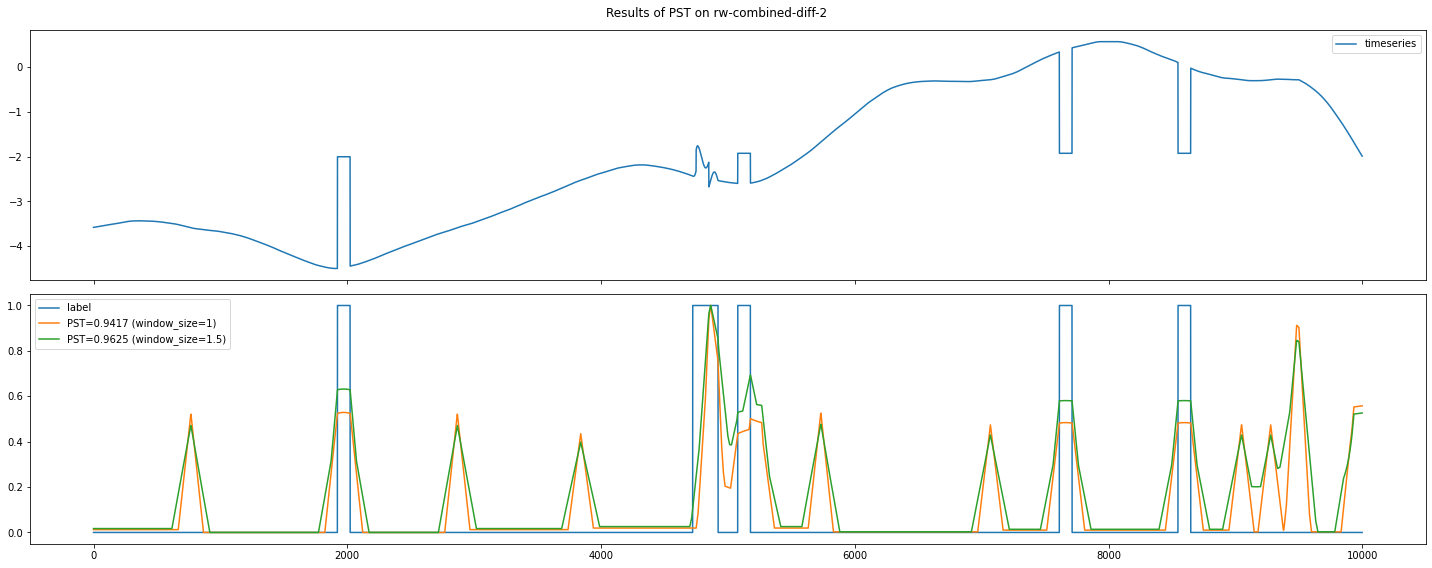

In [29]:
plot_scores([
    ("PST", "window_size", 1),
    ("PST", "window_size", 1.5)
], "rw-combined-diff-2", use_plotly=False)
plt.show()